In [10]:
import numpy as np
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.spatial.distance import cdist, pdist
import itertools
%matplotlib inline

In [53]:
blobs = make_blobs(n_samples=15, n_features=2, centers=5, random_state=42)

In [24]:
tmp_X = blobs[0]
tmp_y= blobs[1]

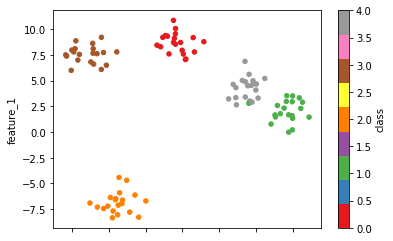

In [25]:
feature_names = ['feature_'+str(i) for i in range(tmp_X.shape[1])]
blobs_df = pd.DataFrame(tmp_X, columns = feature_names)
blobs_df['class'] = tmp_y
blobs_df.head()

blobs_df.plot.scatter(x='feature_0', y='feature_1', c='class', cmap='Set1')

In [54]:
class HierarchicalClusterScratch():
    def __init__(self):
        self.dist_matrix = None # holds distance matrix
        self.dist_queue = None # holds flattened distance matrix, used as a queue for clustering
        self.cluster_hist = None # holds the history of cluster assignment

    def fit(self, X):
        # instantiate some things
        self.__init_dists(X) # distances
        
#         print(self.dist_matrix)
#         print(self.dist_queue)
        
        working_clusters = list(range(len(X))) # each entry in X is assigned a unique cluster 
        self.cluster_hist = [] # cluster history
        self.cluster_hist.append(working_clusters.copy()) #store original state in cluster_history
        
#         print(self.dist_queue)
        
        for dist_i in self.dist_queue:
            # check if all assigned clusters are the same
            if len(set(working_clusters)) == 1:
                break
            
            #identify the observation in X that have dist_i.
            # Take every other entry since you will get [2,4] and [4,2] 
            # but want to be robust against cases were multiple distances have the same value
            indexes_to_be_clustered = np.where(self.dist_matrix==dist_i)[0::2] 
            # I expect the np.where is causing speed issues at scale
            
            
            for X_i in indexes_to_be_clustered:
#                 print(working_clusters)
#                 print(X_i)
                obs_a = X_i[0]
                obs_b = X_i[1]
                
                cluster_a = working_clusters[obs_a]
                cluster_b = working_clusters[obs_b]
                
                count_a = working_clusters.count(cluster_a)
                count_b = working_clusters.count(cluster_b)
                
                # group smaller cluster into the larger. 
                # If they are of equal size, group cluster_a into cluster_b
                if count_a > count_b:
                    working_clusters[obs_b] = cluster_a
                else:
                    working_clusters[obs_a] = cluster_b
                self.cluster_hist.append(working_clusters.copy())
                
                # check if all points are assigned to the same cluster
            if len(set(working_clusters)) == 1:
#                 print("Clustering is complete!")
                break


    def __init_dists(self, X):
        # set distance matrix
        tmp_dist = cdist(X, X)
        np.fill_diagonal(tmp_dist, np.nan) #np.fill_diagonal works IN PLACE
        self.dist_matrix = tmp_dist.copy()
        
        # set flat_dist
        flat_dists = tmp_dist.flatten() #flatten
        flat_dists.sort() # sort in place
        
        #every pairwise distance between points will appear twice (a->b, b->a). 
        #This removes the doubles but preserves any cases where the same distance incidentally occures
        flat_length = len(flat_dists)
        flat_length = range(len(flat_dists))
        flat_length = list(flat_length)[0::2]
        flat_dists = flat_dists[flat_length]
        
        flat_dists = flat_dists[~np.isnan(flat_dists)] # remove np.nans 
        self.dist_queue = flat_dists # should i use list?
        


In [55]:
class HierarchicalClusterScratch_mk2():
    def __init__(self):
        self.dist_queue = None # holds flattened distance matrix, used as a queue for clustering
        self.index_queue = None # holds the index pairs of 
        self.cluster_hist = None # holds the history of cluster assignment

    def fit(self, X):
        # calculate distances and identify order of least to greatest
        self.dist_queue = pdist(X) # distances
        sort_order = self.dist_queue.argsort() #order of least to greatest
#         self.dist_queue = self.dist_queue[sort_order] # not really necessary
            
        # use itertools to quickly generate index pairs
        self.index_queue = itertools.combinations(range(len(X)), 2)
        self.index_queue = np.array(list(self.index_queue)) #type as np.array so it can be reordered using sort_order       
        self.index_queue = self.index_queue[sort_order] #index pairs ordered by distance
        
        # assign initial clusters and instantiate history
        working_clusters = list(range(len(X))) # each entry in X is assigned a unique cluster 
        self.cluster_hist = [] # cluster history
        self.cluster_hist.append(working_clusters.copy()) #store initial state in cluster_history
        
        for X_i in self.index_queue:
            obs_a = X_i[0]
            obs_b = X_i[1]

            cluster_a = working_clusters[obs_a]
            cluster_b = working_clusters[obs_b]

            count_a = working_clusters.count(cluster_a)
            count_b = working_clusters.count(cluster_b)

            # group smaller cluster into the larger. 
            # If they are of equal size, group cluster_a into cluster_b
            if count_a > count_b:
                working_clusters[obs_b] = cluster_a
            else:
                working_clusters[obs_a] = cluster_b
                
            self.cluster_hist.append(working_clusters.copy())
            
            # check if all points are assigned to the same cluster
            if len(set(working_clusters)) == 1:
#                 print("Clustering is complete!")
                break

In [61]:
%%timeit
hc2_scratch = HierarchicalClusterScratch_mk2()
hc2_scratch.fit(blobs[0])

185 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [57]:
hc2_scratch.cluster_hist

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 8, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 14, 3, 4, 5, 6, 8, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 14, 3, 4, 5, 6, 8, 8, 9, 8, 11, 12, 13, 14],
 [0, 1, 14, 3, 4, 5, 6, 8, 8, 9, 8, 11, 12, 13, 14],
 [0, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 12, 13, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 12, 13, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 12, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 12, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 8, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 8, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 8, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 4, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 5, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 5, 8, 8, 14, 8, 11

In [60]:
%%timeit
hc_scratch = HierarchicalClusterScratch()
hc_scratch.fit(blobs[0])

535 µs ± 39.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
pdist(blobs[0])

array([  7.61007297,  13.90072562,   9.82243011,  14.28803524,
        14.87185494,  13.03741896,   1.81248453,   1.01906781,
        14.77154256,   1.39850823,   9.09711043,   1.72972917,
         1.12932761,  14.6524103 ,   7.17206472,   2.55681318,
        14.79778952,  16.06226698,  14.55121184,   5.85342922,
         6.59107566,   7.46684813,   6.65116497,   1.61026809,
         8.87482462,   7.69627618,   7.7452226 ,   6.93621764,
        13.94733298,  15.56002568,  14.69950733,  12.10294613,
        12.94720505,   2.1439722 ,  12.63017426,   6.64184902,
        14.67460036,  13.57256677,   0.86504467,  16.92041336,
        18.26843262,  16.83975526,   8.1558248 ,   8.81407743,
         6.47258827,   9.01328835,   1.00830799,  11.22313811,
        10.05443384,   7.25258406,   1.65309398,   2.03803649,
        13.65476692,  14.13256882,  16.07193206,  13.17955442,
        15.95143179,  13.34852027,  13.18362056,  14.69406856,
         1.84181288,  14.42097187,  14.82285629,  17.67

In [59]:
hc_scratch.cluster_hist

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 8, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 14, 3, 4, 5, 6, 8, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 14, 3, 4, 5, 6, 8, 8, 9, 8, 11, 12, 13, 14],
 [0, 1, 14, 3, 4, 5, 6, 8, 8, 9, 8, 11, 12, 13, 14],
 [0, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 12, 13, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 12, 13, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 12, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 12, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 8, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 8, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 9, 8, 11, 8, 8, 14],
 [8, 1, 14, 11, 4, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 4, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 6, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 5, 8, 8, 14, 8, 11, 8, 8, 14],
 [8, 11, 14, 11, 5, 5, 5, 8, 8, 14, 8, 11

In [30]:
from sklearn.cluster import AgglomerativeClustering

In [63]:
%%timeit
hc_sklearn = AgglomerativeClustering()
hc_sklearn.fit(blobs[0])

196 µs ± 9.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
